In [1]:
%pip install mediapipe
%pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from DatasetAngle import SquatPhaseDataset
from collections import deque
from sklearn.preprocessing import StandardScaler
import cv2
import mediapipe as mp

from tqdm.notebook import trange, tqdm

In [3]:
CONFIG = {
    'input_size': 5,  # Will be set automatically
    'hidden_size': 128,  # Increased hidden size
    'num_layers': 2,  # Increased LSTM layers
    'lr': 0.01,       # Higher initial learning rate
    'batch_size': 32,
    'epochs': 50,
    'min_velocity': 0.02,
    'sigma': 2.5,
    'early_stopping_patience': 5,
    'class_weights': torch.tensor([1.0, 1.0, 1.0])  # Add class weights (e.g., for UP, DOWN, STABLE)
}

In [4]:
class WeightedFocalLoss(nn.Module):
    def __init__(self, class_weights, alpha=0.25, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.class_weights = class_weights

    def forward(self, inputs, targets):
        # Convert targets to long (integers) for CrossEntropyLoss
        targets = targets.long()
        
        # CrossEntropyLoss is used for multi-class classification
        ce_loss = nn.CrossEntropyLoss(weight=self.class_weights)(inputs, targets)
        
        # Compute the focal loss component
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

In [5]:
class PhaseLSTM(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=CONFIG['hidden_size'],
            num_layers=CONFIG['num_layers'],
            batch_first=True
        )
        self.classifier = nn.Sequential(
            nn.Linear(CONFIG['hidden_size'], 3)  # Output 3 classes (for UP, DOWN, STABLE)
        )
        
        # Initialize weights properly
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0.1)

    def forward(self, x):
        x = x.float()
        out, _ = self.lstm(x)
        return self.classifier(out[:, -1])  # Output the last time step

In [6]:
def check_feature_distributions(dataset):
    """Analyze feature distributions by class"""
    features_up = []
    features_down = []
    features_stable = []
    
    for seq, label in dataset:
        if label == 0:  # UP
            features_up.append(seq.numpy())
        elif label == 1:  # DOWN
            features_down.append(seq.numpy())
        else:  # STABLE
            features_stable.append(seq.numpy())
    
    features_up = np.concatenate(features_up)
    features_down = np.concatenate(features_down)
    features_stable = np.concatenate(features_stable)
    
    print("\n=== Feature Statistics ===")
    print(f"UP samples: {len(features_up)}")
    print(f"DOWN samples: {len(features_down)}")
    print(f"STABLE samples: {len(features_stable)}")
    
    plt.figure(figsize=(15, 8))
    num_features = min(5, features_up.shape[1])  # Ensure we only use available features
    for i in range(num_features):
        plt.subplot(2, 3, i+1)
        plt.hist(features_up[:, i].ravel(), bins=50, alpha=0.5, label='UP')
        plt.hist(features_down[:, i].ravel(), bins=50, alpha=0.5, label='DOWN')
        plt.hist(features_stable[:, i].ravel(), bins=50, alpha=0.5, label='STABLE')
        plt.title(f'Feature {i} Distribution')
        plt.legend()
    plt.tight_layout()
    plt.show()

In [7]:
def prepare_loaders():
    train_set = SquatPhaseDataset("Squat_Train.csv", 
                                seq_length=30,
                                min_velocity=CONFIG['min_velocity'],
                                sigma=CONFIG['sigma'])
    
    val_set = SquatPhaseDataset("Squat_Test.csv",
                              seq_length=30,
                              min_velocity=CONFIG['min_velocity'],
                              sigma=CONFIG['sigma'])

    # Run diagnostics
    print("=== Training Set Diagnostics ===")
    check_feature_distributions(train_set)
    
    CONFIG['input_size'] = train_set.data[0].shape[1]

    train_loader = DataLoader(
        train_set,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        collate_fn=train_set.collate_fn
    )
    
    val_loader = DataLoader(
        val_set,
        batch_size=CONFIG['batch_size'],
        collate_fn=val_set.collate_fn
    )
    
    return train_loader, val_loader

In [8]:
def train_model(train_loader, val_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = PhaseLSTM(CONFIG['input_size']).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['lr'])
    criterion = WeightedFocalLoss(class_weights=CONFIG['class_weights'])  # Use Weighted Focal Loss
    
    # Tracking variables
    grad_norms = []
    best_f1 = 0
    patience_counter = 0
    best_model_path = "best_model.pth"
    
    for epoch in range(CONFIG['epochs']):
        model.train()
        train_loss = 0
        current_grad_norms = []
    
        for seq, labels in train_loader:
            seq, labels = seq.to(device), labels.long().to(device)  # Convert labels to integers
            
            optimizer.zero_grad()
            outputs = model(seq)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Calculate gradient norm
            total_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            grad_norm = total_norm ** 0.5
            current_grad_norms.append(grad_norm)
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        # Store gradient norms
        grad_norms.extend(current_grad_norms)
        
        # Validation
        val_metrics = evaluate(model, val_loader, device)
    
        print(f"\nEpoch {epoch+1}/{CONFIG['epochs']}:")
        print(f"  Train Loss: {train_loss/len(train_loader):.4f}")
        print(f"  Val Acc: {val_metrics['accuracy']:.4f}")
        print(f"  Val F1: {val_metrics['f1']:.4f}")
        print(f"  Avg Grad Norm: {np.mean(current_grad_norms):.4f}")
        print(f"  Confusion Matrix:\n{val_metrics['confusion_matrix']}")
        
        # Early stopping and learning rate adjustment
        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
        else:
            patience_counter += 1
            if patience_counter >= CONFIG['early_stopping_patience']:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break
            
            # Reduce learning rate if no improvement
            if patience_counter % 2 == 0:
                for g in optimizer.param_groups:
                    g['lr'] *= 0.5
                print(f"Reducing learning rate to {optimizer.param_groups[0]['lr']:.2e}")
    
    # Plot training curves
    plt.figure(figsize=(12, 4))
    plt.plot(grad_norms)
    plt.title("Gradient Norms During Training")
    plt.xlabel("Iteration")
    plt.ylabel("Gradient Norm")
    plt.show()
    
    return model

In [9]:
def evaluate(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for seq, labels in loader:
            seq = seq.to(device)
            outputs = model(seq).cpu()
            preds = torch.argmax(outputs, dim=1)  # Using argmax for multi-class classification
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Compute precision, recall, and F1 score for each class
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    return {
        'accuracy': (all_preds == all_labels).mean(),
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }

=== Training Set Diagnostics ===

=== Feature Statistics ===
UP samples: 1890
DOWN samples: 1530
STABLE samples: 26790


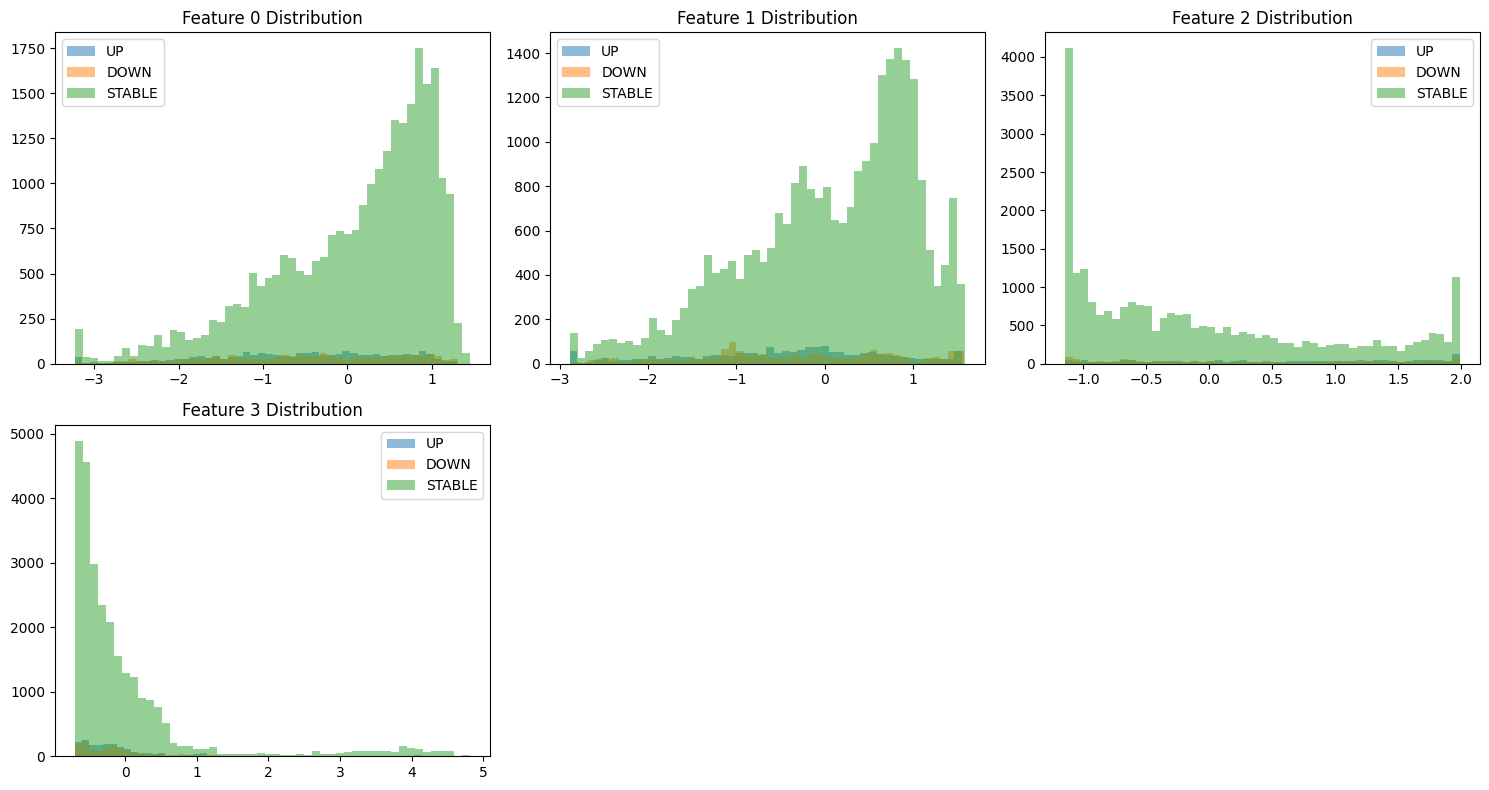


=== Starting Training ===

Epoch 1/50:
  Train Loss: 0.0224
  Val Acc: 0.9032
  Val F1: 0.8573
  Avg Grad Norm: 0.0603
  Confusion Matrix:
[[  0   0  16]
 [  0   0  11]
 [  0   0 252]]

Epoch 2/50:
  Train Loss: 0.0092
  Val Acc: 0.8781
  Val F1: 0.8728
  Avg Grad Norm: 0.0183
  Confusion Matrix:
[[ 14   0   2]
 [  0   0  11]
 [ 21   0 231]]

Epoch 3/50:
  Train Loss: 0.0109
  Val Acc: 0.9032
  Val F1: 0.8573
  Avg Grad Norm: 0.0271
  Confusion Matrix:
[[  0   0  16]
 [  0   0  11]
 [  0   0 252]]

Epoch 4/50:
  Train Loss: 0.0104
  Val Acc: 0.8746
  Val F1: 0.8676
  Avg Grad Norm: 0.0196
  Confusion Matrix:
[[ 11   0   5]
 [  0   0  11]
 [ 19   0 233]]
Reducing learning rate to 5.00e-03

Epoch 5/50:
  Train Loss: 0.0068
  Val Acc: 0.9068
  Val F1: 0.8700
  Avg Grad Norm: 0.0219
  Confusion Matrix:
[[  0   0  16]
 [  0   2   9]
 [  0   1 251]]

Epoch 6/50:
  Train Loss: 0.0048
  Val Acc: 0.9176
  Val F1: 0.9092
  Avg Grad Norm: 0.0289
  Confusion Matrix:
[[  6   0  10]
 [  0   4   7]


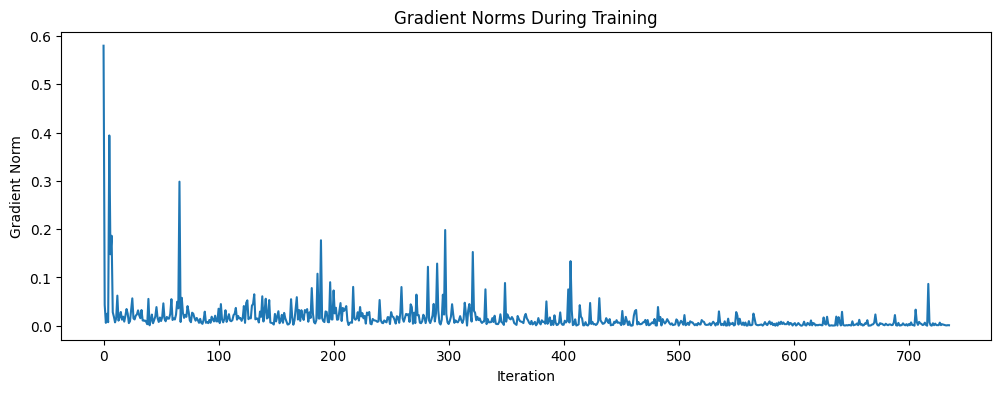


=== Final Evaluation ===
Accuracy: 0.9713
Precision: 0.9707
Recall: 0.9713
F1 Score: 0.9707
Confusion Matrix:
[[ 14   0   2]
 [  0   8   3]
 [  2   1 249]]

=== Training Complete ===


In [10]:
train_loader, val_loader = prepare_loaders()
    
# Train model
print("\n=== Starting Training ===")
model = train_model(train_loader, val_loader)

# Final evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
final_metrics = evaluate(model, val_loader, device)
        
print("\n=== Final Evaluation ===")
print(f"Accuracy: {final_metrics['accuracy']:.4f}")
print(f"Precision: {final_metrics['precision']:.4f}")
print(f"Recall: {final_metrics['recall']:.4f}")
print(f"F1 Score: {final_metrics['f1']:.4f}")
print("Confusion Matrix:")
print(final_metrics['confusion_matrix'])
print("\n=== Training Complete ===")

In [11]:
class ResBlockMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResBlockMLP, self).__init__()
        self.norm1 = nn.LayerNorm(input_size)
        self.fc1 = nn.Linear(input_size, input_size//2)
        self.norm2 = nn.LayerNorm(input_size//2)
        self.fc2 = nn.Linear(input_size//2, output_size)
        self.fc3 = nn.Linear(input_size, output_size)
        self.act = nn.ELU()

    def forward(self, x):
        x = self.act(self.norm1(x))
        skip = self.fc3(x)
        x = self.act(self.norm2(self.fc1(x)))
        x = self.fc2(x)
        return x + skip

# Define the LSTM model for squat data
class SquatLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_res_blocks=1):
        super(SquatLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # No initial fully connected layer needed as input is already feature vectors
        # self.fc_in = nn.Linear(patch_size**2, hidden_size) # Removed

        # LSTM layer takes the feature vector directly
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        # Define residual blocks
        blocks = [ResBlockMLP(hidden_size, hidden_size) for _ in range(num_res_blocks)]
        self.res_blocks = nn.Sequential(*blocks)

        # Output layer: 2 classes (going up or going down)
        self.fc_out = nn.Linear(hidden_size, output_size)
        self.act = nn.ELU()

    def forward(self, input_seq, hidden, cell):
        # Input shape: (batch_size, sequence_length, input_size)
        # No need to extract patches, the input is already the sequence of joint features

        # LSTM expects input of shape (batch_size, seq_len, input_size)
        output, (hidden, cell) = self.lstm(input_seq, (hidden, cell))

        # We are interested in the output of the last time step for many-to-one classification
        # output shape: (batch_size, sequence_length, hidden_size)
        last_output = output[:, -1, :]

        x = self.act(self.res_blocks(last_output))
        output = self.fc_out(x)
        return output, hidden, cell

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(self.lstm.weight.device),
                    weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(self.lstm.weight.device))
        return hidden

In [12]:
def load_model(model_path, input_size=4):
    model = PhaseLSTM(input_size)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

In [13]:
class SquatAnalyzer:
    def __init__(self, model_path, seq_length=30):
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )
        self.mp_drawing = mp.solutions.drawing_utils
        self.model = load_model(model_path)
        self.seq_length = seq_length
        self.sequence = deque(maxlen=seq_length)
        self.scaler = StandardScaler()
        self.scaler.mean_ = np.array([  # Replace with your actual scaler means
            1.57079633, 1.57079633, 0.78539816, 0.0
        ])
        self.scaler.scale_ = np.array([  # Replace with your actual scaler scales
            0.52359878, 0.52359878, 0.26179939, 0.26179939
        ])
        
        # Joint indices (MediaPipe Pose landmarks)
        self.joint_indices = {
            'left_shoulder': 11,
            'right_shoulder': 12,
            'left_hip': 23,
            'right_hip': 24,
            'left_knee': 25,
            'right_knee': 26,
            'left_ankle': 27,
            'right_ankle': 28
        }
        
        # Visualization settings
        self.colors = {
            'UP': (0, 255, 0),    # Green
            'DOWN': (0, 0, 255),   # Red
            'STABLE': (255, 255, 0) # Yellow
        }
        self.class_names = {0: 'DOWN', 1: 'UP', 2: 'STABLE'}

    def calculate_angles(self, landmarks):
        """Calculate the same angles as in your training data"""
        joints = {}
        for name, idx in self.joint_indices.items():
            landmark = landmarks.landmark[idx]
            joints[name] = np.array([landmark.x, landmark.y, landmark.z])
        
        # Calculate vectors (same as in DatasetAngle.py)
        left_thigh = joints['left_hip'] - joints['left_knee']
        left_shin = joints['left_ankle'] - joints['left_knee']
        right_thigh = joints['right_hip'] - joints['right_knee']
        right_shin = joints['right_ankle'] - joints['right_knee']
        torso = ((joints['left_shoulder'] + joints['right_shoulder']) / 2 - 
                (joints['left_hip'] + joints['right_hip']) / 2)

        # Same safe_angle function as in DatasetAngle.py
        def safe_angle(v1, v2, min_deg=10, max_deg=170):
            cos = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-8)
            return np.clip(np.arccos(cos), np.radians(min_deg), np.radians(max_deg))

        return np.array([
            safe_angle(left_thigh, left_shin, 60, 180),    # Left knee
            safe_angle(right_thigh, right_shin, 60, 180),   # Right knee
            safe_angle(torso, left_thigh, 10, 90),          # Left hip
            np.arctan2(torso[1], abs(torso[2]))            # Torso lean
        ])

    def process_frame(self, frame):
        """Process a single frame and return prediction"""
        # Convert BGR to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        # Make detection
        results = self.pose.process(image)
        
        # Reset writeable flag and convert back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        if results.pose_landmarks:
            # Calculate angles
            angles = self.calculate_angles(results.pose_landmarks)
            
            # Scale angles (same as during training)
            scaled_angles = self.scaler.transform([angles])[0]
            
            # Add to sequence
            self.sequence.append(scaled_angles)
            
            # Make prediction if we have enough frames
            if len(self.sequence) == self.seq_length:
                # Convert to tensor and add batch dimension
                input_tensor = torch.FloatTensor(np.array(self.sequence)).unsqueeze(0)
                
                # Predict
                with torch.no_grad():
                    outputs = self.model(input_tensor)
                    prediction = torch.argmax(outputs).item()
                
                current_phase = self.class_names[prediction]
            else:
                current_phase = "Initializing..."
            
            # Draw landmarks and prediction
            self.mp_drawing.draw_landmarks(
                image, results.pose_landmarks, self.mp_pose.POSE_CONNECTIONS)
            
            # Display prediction
            cv2.putText(image, f"Phase: {current_phase}", 
                        (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                        1, self.colors.get(current_phase, (255, 255, 255)), 2)
        
        return image

    def analyze_video(self, video_source=0):
        """Run analysis on video source (0 for webcam or file path)"""
        cap = cv2.VideoCapture(video_source)
        
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
                
            # Process frame
            output_frame = self.process_frame(frame)
            
            # Display
            cv2.imshow('Squat Phase Detection', output_frame)
            
            # Exit on 'q'
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
                
        cap.release()
        cv2.destroyAllWindows()

In [14]:
analyzer = SquatAnalyzer("best_model.pth")
analyzer.analyze_video("AllVids/Squat_New1.mp4")

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1743965133.583371   70190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743965133.642913   70190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743965133.661434   70196 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


: 

End of video.
